# Kalman filter for Nomoto model
A Kalman filter with a Nomoto model as the predictor will be developed.
The filter is run on simulated data as well as real model test data.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import sympy as sp

import src.visualization.book_format as book_format
book_format.set_style()
from src.substitute_dynamic_symbols import lambdify
from sympy import Matrix
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify
from sympy.physics.vector.printing import vpprint, vlatex
from src.data import mdl

## Nomoto model for ship manoeuvring dynamics
The Nomoto model can be written as:

In [2]:
r,r1d,r2d = sp.symbols('r \dot{r} \ddot{r}')
psi,psi1d = sp.symbols('psi \dot{\psi}')
h,u = sp.symbols('h u')
x, x1d = sp.symbols('x \dot{x}')
A,B,C,D,E, Phi = sp.symbols('A B C D E Phi')
w = sp.symbols('w')

K, delta, T_1, T_2 = sp.symbols('K delta T_1 T_2')

eq_nomoto = sp.Eq(K*delta,
                 r + T_1*r1d + T_2*r2d)
Math(vlatex(eq_nomoto))

<IPython.core.display.Math object>

where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term into a first order Nomoto model:

In [3]:
eq_nomoto_simple = eq_nomoto.subs(r2d,0)
Math(vlatex(eq_nomoto_simple))

<IPython.core.display.Math object>

### Simulation model

In [4]:
eq_system = sp.Eq(x1d, A*x + B*u + E*w)
eq_system

Eq(\dot{x}, A*x + B*u + E*w)

Where the state vector $x$:

In [5]:
eq_x = sp.Eq(x, sp.UnevaluatedExpr(Matrix([psi,r])))
eq_x

Eq(x, Matrix([
[psi],
[  r]]))

and input vector $u$:

In [6]:
eq_u = sp.Eq(u, sp.UnevaluatedExpr(Matrix([delta])))
eq_u

Eq(u, Matrix([[delta]]))

and $w$ is zero mean Gausian process noise

For the nomoto model the time derivatives for the states can be expressed as:

In [7]:
eq_psi1d = sp.Eq(psi1d,r)
eq_psi1d

Eq(\dot{\psi}, r)

In [8]:
eq_r1d = sp.Eq(r1d,sp.solve(eq_nomoto_simple,r1d)[0])
eq_r1d

Eq(\dot{r}, (K*delta - r)/T_1)

So that matrix $A$ can be expressed as:

In [9]:
eqs = (eq_psi1d, eq_r1d,)
A_,b_ =sp.linear_eq_to_matrix(eqs, list(eq_x.rhs.doit()))
eq_A = sp.Eq(A, sp.UnevaluatedExpr(-A_))
eq_A

Eq(A, Matrix([
[0,      1],
[0, -1/T_1]]))

and $B$ as:

In [10]:
B_,b_ =sp.linear_eq_to_matrix(eqs, list(eq_u.rhs.doit()))
eq_B = sp.Eq(B,sp.UnevaluatedExpr(B_))
eq_B

Eq(B, Matrix([
[     0],
[-K/T_1]]))

### Discrete time step model

The first term of a taylor expansion of $A$ can be written as:

In [11]:
eq_Phi = sp.Eq(Phi, sp.UnevaluatedExpr(sp.eye(2)) + sp.UnevaluatedExpr(eq_A.rhs.doit()*h))
display(eq_Phi)
#eq_Phi = sp.Eq(Phi, eq_Phi.rhs.doit())

Eq(Phi, Matrix([
[0,      h],
[0, -h/T_1]]) + Matrix([
[1, 0],
[0, 1]]))

In [12]:
A_d,B_d = sp.symbols('A_d B_d')

The discrete state transition matrixes can then be written:

In [13]:
eq_A_d=sp.Eq(A_d,Phi)
eq_A_d

Eq(A_d, Phi)

In [14]:
eq_B_d = sp.Eq(B_d,B*h)
eq_B_d

Eq(B_d, B*h)

## Simulation
Simulation with this model where rudder angle shifting between port and starboard

In [15]:
lambda_Ad = lambdify(eq_Phi.rhs.doit())
lambda_Bd = lambdify(eq_B.rhs.doit()*h)

T_1_ = 1.8962353076056344
K_ = 0.17950970687951323
h_ = 0.02

Ad_=lambda_Ad(T_1=T_1_, h=h_)
Bd_=lambda_Bd(K=K_, T_1=T_1_, h=h_)

In [16]:
def simulate(Ad, Bd, E,ws, t, us):
    
    simdata = []
    x_=np.deg2rad(np.array([[0,0]]).T)
    for u_,w_ in zip(us,ws):
               
        x_ = (Ad@x_ + Bd*u_) + E * w_
    
        simdata.append(x_.flatten())
        
    simdata = np.array(simdata)
    df = pd.DataFrame(simdata, columns=["psi","r"], index=t)
    df['delta'] = us
    
    return df

In [17]:
N_ = 4000

t_ = np.arange(0,N_*h_,h_)
    
us = np.deg2rad(np.concatenate((-10*np.ones(int(N_/4)),
                                10*np.ones(int(N_/4)),
                                -10*np.ones(int(N_/4)),
                                10*np.ones(int(N_/4)))))

np.random.seed(42)
E = np.array([[0, 1]]).T
process_noise = np.deg2rad(0.01)
ws = process_noise*np.random.normal(size=N_)
df = simulate(Ad=Ad_, Bd=Bd_, E=E, ws=ws, t=t_, us=us)

measurement_noise = np.deg2rad(0.5)
df['epsilon'] = measurement_noise*np.random.normal(size=N_)
df['psi_measure'] = df['psi'] + df['epsilon']
df['psi_deg'] = np.rad2deg(df['psi'])
df['psi_measure_deg'] = np.rad2deg(df['psi_measure'])
df['delta_deg'] = np.rad2deg(df['delta'])


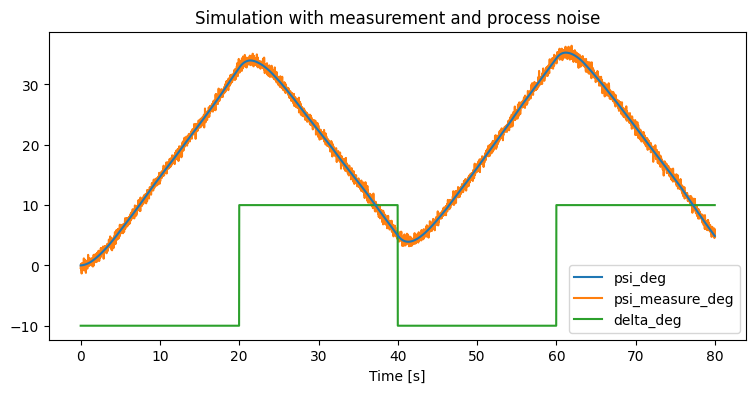

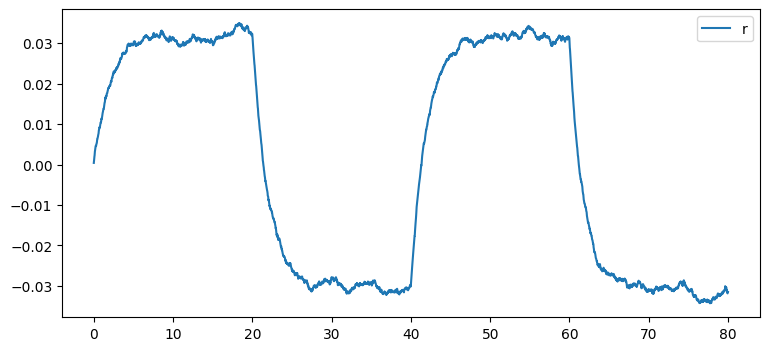

In [18]:
fig,ax=plt.subplots()
df.plot(y='psi_deg', ax=ax)
df.plot(y='psi_measure_deg', ax=ax, zorder=-1)
df.plot(y='delta_deg', ax=ax, zorder=-1)
df.plot(y='r')
ax.set_title('Simulation with measurement and process noise')
ax.set_xlabel('Time [s]');



## Kalman filter
Implementation of the Kalman filter. The code is inspired of this Matlab implementation: [ExKF.m](https://github.com/cybergalactic/MSS/blob/master/mssExamples/ExKF.m).

In [19]:
def ssa(angle):
    """
    maps an angle in rad to the interval [-pi pi]
    """
    return np.mod(angle + np.pi, 2 * np.pi) - np.pi


def filter_yaw(
    x0: np.ndarray,
    P_prd: np.ndarray,
    h_m: float,
    h: float,
    us: np.ndarray,
    ys: np.ndarray,
    Ad: np.ndarray,
    Bd: np.ndarray,
    Cd: np.ndarray,
    Ed: np.ndarray,
    Qd: float,
    Rd: float,
) -> pd.DataFrame:
    """kalman filter for yaw

    Parameters
    ----------
    x0 : np.ndarray
        initial state [yaw, yaw rate]
    P_prd : np.ndarray
        nxn array: initial covariance matrix
    h_m : float
        time step measurement [s]
    h : float
        time step filter [s]
    us : np.ndarray
        1D array: inputs
    ys : np.ndarray
        1D array: measured yaw
    Ad : np.ndarray
        nxn array: discrete time transition matrix
    Bd : np.ndarray
        nx1 array: discrete time input transition matrix
    Cd : np.ndarray
        1xn array: measurement transition matrix
    Ed : np.ndarray
        nx1 array
    Qd : float
        process noise
    Rd : float
        measurement noise

    Returns
    -------
    list
        list with data from each time step as dictionary
    """
    x_prd = x0
    t = 0
    n = len(Ad)  # Number of states

    time_steps = []
    for i in range(len(us)):

        u = us[i]  # input
        y = ys[i].T  # measurement

        for j in range(int(h_m / h)):
            t += h
            # Compute kalman gain:
            S = Cd @ P_prd @ Cd.T + Rd  # System uncertainty
            K = P_prd @ Cd.T @ inv(S)
            IKC = np.eye(n) - K @ Cd

            # State corrector:
            x_hat = x_prd + K * ssa(y - Cd @ x_prd)  # smallest signed angle

            # corrector
            P_hat = IKC * P_prd @ IKC.T + K * Rd @ K.T

            # Predictor (k+1)
            x_prd = Ad @ x_hat + Bd * u
            P_prd = Ad @ P_hat @ Ad.T + Ed @ Qd @ Ed.T

            time_step = {
                "x_hat": x_hat.flatten(),
                "P_hat": P_hat,
                "time": t,
                "K": K.flatten(),
            }
            time_steps.append(time_step)

    return time_steps

In [20]:
x0=np.deg2rad(np.array([[0,0]]).T)
P_prd = np.diag(np.deg2rad([1, 0.1]))

Qd = np.deg2rad(np.diag([0, 0.5]))

Rd = np.deg2rad(1)

ys = df['psi_measure'].values

E_ = np.array(
    [[0,0], [0,1]],
)

C_ = np.array([[1, 0]])

Cd_ = C_
Ed_ = h_ * E_

time_steps = filter_yaw(x0=x0, P_prd=P_prd,h_m=h_,h=h_, us=us, ys=ys, Ad=Ad_, Bd=Bd_, Cd=Cd_, Ed=Ed_, Qd=Qd, Rd=Rd)
x_hats = np.array([time_step["x_hat"] for time_step in time_steps]).T
time = np.array([time_step["time"] for time_step in time_steps]).T
Ks = np.array([time_step["K"] for time_step in time_steps]).T


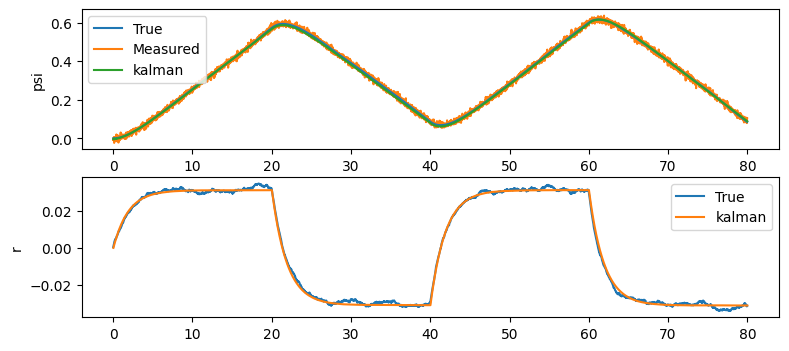

In [21]:
n=len(Ad_)
fig,axes=plt.subplots(nrows=n)

keys = ['psi','r']
for i,key in enumerate(keys):
    
    ax=axes[i]
    df.plot(y=key, ax=ax, label="True")
    if key=='psi':
        df.plot(y='psi_measure', ax=ax, label="Measured", zorder=-1)
    
    ax.plot(time, x_hats[i, :], "-", label="kalman")
    ax.set_ylabel(key)
    ax.legend()

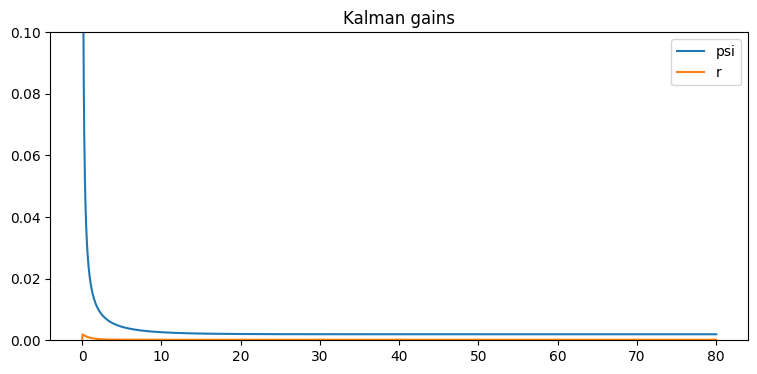

In [22]:
fig,ax=plt.subplots()
for i,key in enumerate(keys):
    ax.plot(time,Ks[i,:],label=key)
ax.set_title('Kalman gains')
ax.legend();
ax.set_ylim(0,0.1);


# Real data
Using the developed Kalman filter on some real model test data

## Load test

In [23]:
id=22773
df, units, meta_data = mdl.load(dir_path = '../../data/raw', id=id)
df.index = df.index.total_seconds()
df.index-=df.index[0]

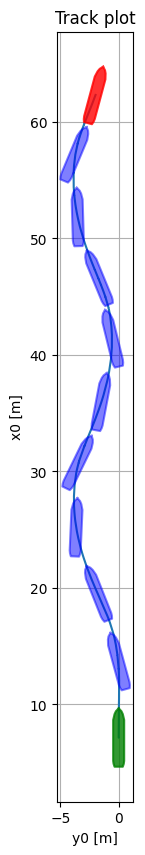

In [24]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

In [25]:
ys = df['psi'].values
h_m=h_ = df.index[1]-df.index[0]
x0=np.deg2rad(np.array([[0,0]]).T)
us = df['delta'].values

P_prd = np.diag(np.deg2rad([1, 0.1]))
Qd = np.deg2rad(np.diag([0, 5]))
Rd = np.deg2rad(0.1)

time_steps = filter_yaw(x0=x0, P_prd=P_prd,h_m=h_,h=h_, us=us, ys=ys, Ad=Ad_, Bd=Bd_, Cd=Cd_, Ed=Ed_, Qd=Qd, Rd=Rd)
x_hats = np.array([time_step["x_hat"] for time_step in time_steps]).T
time = np.array([time_step["time"] for time_step in time_steps]).T
Ks = np.array([time_step["K"] for time_step in time_steps]).T

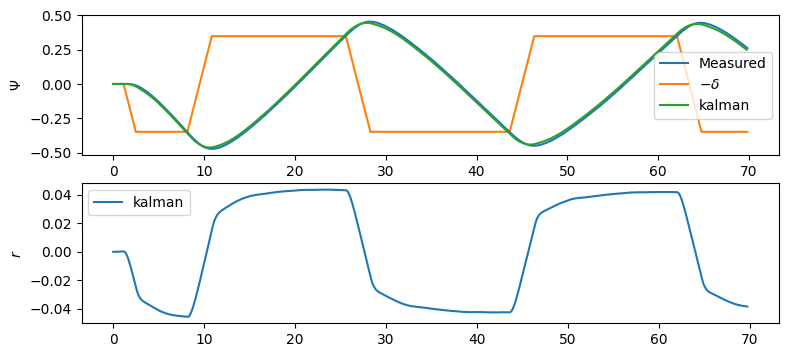

In [26]:
n=len(Ad_)
fig,axes=plt.subplots(nrows=n)

    
ax=axes[0]
df.plot(y='psi', ax=ax, label="Measured", zorder=-1)
df['-delta']=-df['delta']
df.plot(y='-delta', ax=ax, label='$-\delta$', zorder=-10)
ax.plot(time, x_hats[0, :], "-", label="kalman", zorder=10)
ax.set_ylabel('$\Psi$')
ax.legend()

ax=axes[1]
ax.plot(time, x_hats[1, :], "-", label="kalman")
ax.set_ylabel('$r$')

ax.legend();